# Importing the Dependencies'

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor as XGB
from sklearn import metrics
import math
from sklearn.utils import shuffle

In [6]:
%matplotlib inline
#import arviz as az
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
#import graphviz
import os

In [7]:
#import pymc3 as pm

# Data Collection and Processing

In [8]:
# loading the data from csv file to pandas dataframe
df = pd.read_csv('/Users/insomni_.ak/Documents/Machine Learning/GIAN_CMC/input/data_Aug20.csv',index_col=False)

In [10]:
# saving the feature names into a list
f_name=list(df.columns)
lenn=len(f_name)

for i in range(0,lenn):
    print(i, " = ",f_name[i])

0  =  Fabrication Temperature 
1  =  Fabrication Time
2  =  Fiber Density
3  =  Number of Fibers per Tow
4  =  Fiber Volume Fractions
5  =  Fiber Radius
6  =  Fiber Tensile Modulus or Young modulus or Tensile Modulus
7  =  Matrix Volume Fraction
8  =  Tensile Testing Temperature
9  =  Tensile Strength 


In [11]:
#renaming features
df = df.rename(columns={'Fiber Tensile Modulus or Young modulus or Tensile Modulus': 'Fiber Modulus', 'Tensile Strength ': 'Strength','Tensile Fracture Strain':'Strain'})

In [12]:
# inspecting the first 5 rows of the dataframe
df.head()

,Fabrication Temperature,Fabrication Time,Fiber Density,Number of Fibers per Tow,Fiber Volume Fractions,Fiber Radius,Fiber Modulus,Matrix Volume Fraction,Tensile Testing Temperature,Strength
0,1000,NaN,2.884,500.0,0.446,6.0,NaN,0.69,900.0,950.000
1,1000,NaN,2.884,500.0,0.660,6.5,354.0,0.34,20.0,1200.000
2,1060,NaN,2.252,400.0,0.270,NaN,195.0,0.73,NaN,664.760
3,1400,NaN,2.900,NaN,0.270,NaN,171.0,NaN,NaN,310.798
4,1000,NaN,2.884,500.0,0.580,6.5,NaN,0.30,NaN,796.800


In [13]:
# df.drop(df.columns[[0, 1, 2,7,11,15]], axis=1, inplace=True)

In [14]:
# saving the feature names into a list
f_name=list(df.columns)
lenn=len(f_name)

for i in range(0,lenn):
    print(i, " = ",f_name[i])

0  =  Fabrication Temperature 
1  =  Fabrication Time
2  =  Fiber Density
3  =  Number of Fibers per Tow
4  =  Fiber Volume Fractions
5  =  Fiber Radius
6  =  Fiber Modulus
7  =  Matrix Volume Fraction
8  =  Tensile Testing Temperature
9  =  Strength


In [15]:
# checking the number of rows and columns
df.shape

(109, 10)

In [16]:
# getting some information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Fabrication Temperature      109 non-null    int64  
 1   Fabrication Time             60 non-null     float64
 2   Fiber Density                79 non-null     float64
 3   Number of Fibers per Tow     84 non-null     float64
 4   Fiber Volume Fractions       107 non-null    float64
 5   Fiber Radius                 76 non-null     float64
 6   Fiber Modulus                76 non-null     float64
 7   Matrix Volume Fraction       72 non-null     float64
 8   Tensile Testing Temperature  72 non-null     float64
 9   Strength                     95 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 8.6 KB


In [17]:
df=shuffle(df)

In [19]:
# checking the number of missing values
df.isnull().sum()

Fabrication Temperature         0
Fabrication Time               49
Fiber Density                  30
Number of Fibers per Tow       25
Fiber Volume Fractions          2
Fiber Radius                   33
Fiber Modulus                  33
Matrix Volume Fraction         37
Tensile Testing Temperature    37
Strength                       14
dtype: int64

In [ ]:
# #dealing with the missing values
# #mean
# df.fillna(df.mean(), inplace=True)

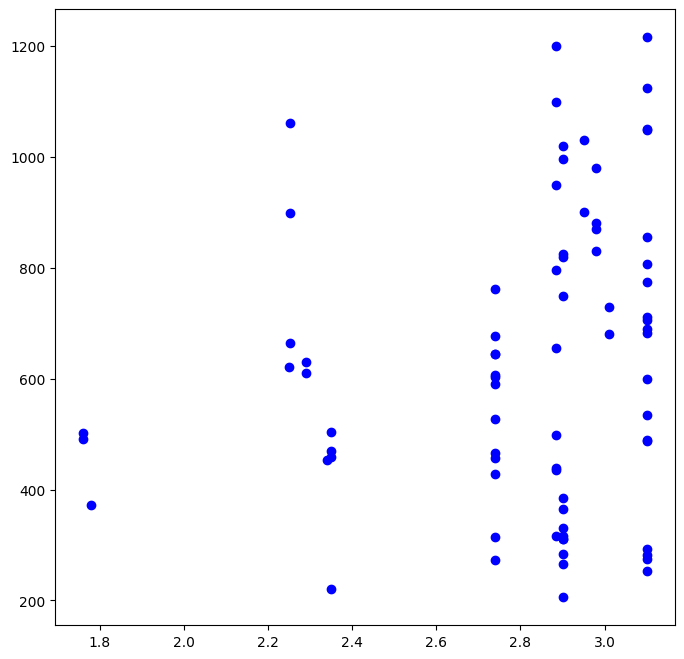

In [20]:
plt.figure(figsize=(8, 8))
plt.plot(df['Fiber Density'], df['Strength'], 'bo')


In [21]:
t=int(input("1 for mean, 2 for -1, 3 for KNeighborsRegressor: "))
if(t==1):
    print("Opted for mean\n")
    df.fillna(df.mean(),inplace=True)
elif(t==2):
    print("Opted for -1\n")
    df.fillna(value=-1,inplace=True)
else:
    print("Opted for KNeighborsRegressor\n")
    from sklearn.neighbors import KNeighborsRegressor

# function that imputes a dataframe
    def impute_knn(df):

        ''' inputs: pandas df containing feature matrix '''
        ''' outputs: dataframe with NaN imputed '''
        # imputation with KNN unsupervised method

        # separate dataframe into numerical/categorical
        ldf = df.select_dtypes(include=[np.number])           # select numerical columns in df
        ldf_putaside = df.select_dtypes(exclude=[np.number])  # select categorical columns in df
        # define columns w/ and w/o missing data
        cols_nan = ldf.columns[ldf.isna().any()].tolist()         # columns w/ nan
        cols_no_nan = ldf.columns.difference(cols_nan).values     # columns w/o nan

        for col in cols_nan:
            imp_test = ldf[ldf[col].isna()]   # indicies which have missing data will become our test set
            imp_train = ldf.dropna()          # all indicies which which have no missing data
            model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
            knr = model.fit(imp_train[cols_no_nan], imp_train[col])
            ldf.loc[df[col].isna(), col] = knr.predict(imp_test[cols_no_nan])

        return pd.concat([ldf,ldf_putaside],axis=1)
    # Call function that imputes missing data
    df = impute_knn(df)


Opted for KNeighborsRegressor



In [22]:
df.isna().sum().sort_values(ascending=False)

Fabrication Temperature        0
Fabrication Time               0
Fiber Density                  0
Number of Fibers per Tow       0
Fiber Volume Fractions         0
Fiber Radius                   0
Fiber Modulus                  0
Matrix Volume Fraction         0
Tensile Testing Temperature    0
Strength                       0
dtype: int64

In [24]:
df.to_csv('/Users/insomni_.ak/Documents/Machine Learning/GIAN_CMC/input/out.csv', index=False)  

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(df['Fiber Density'], df['Strength'], 'bo');

### Correlation Before Adding more features for Solving Underfitting.

In [ ]:
''' Function to plot correlation of features '''
def corrMat(df,id=False):

    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0,
                cmap='plasma',square=False,lw=2,annot=True,cbar=False);plt.show()

In [ ]:
corrMat(df)

### Solving Underfitting

In [ ]:
df['Fiber Radius-2']=df['Fiber Radius']*2+df['Fiber Radius']*3
df['Fiber Volume Fractions-2']=df['Fiber Volume Fractions']*2+df['Fiber Radius-2']
df['Fiber Volume Fractions-3']=df['Fiber Volume Fractions']*3+df['Fiber Radius-2']*2

df['Fiber Modulus-2']=np.sqrt(df['Fiber Modulus'])

In [ ]:
# checking the distribution of categorical data
## checking for missing values
df.isnull().sum()

In [ ]:
f_name=list(df.columns)
train=[x for i,x in enumerate(f_name) if i!=9]
test=f_name[9]

In [ ]:
train
test

In [ ]:
df.head()

In [ ]:
#e




### Distribution Plots

In [ ]:
#features=["Interphase Code","PyC","SiC","BN","Overall Interphase thickness","Fiber Density","Fiber Volume Fractions","Fabrication Temperature "]

In [ ]:
# distribution of strength value
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(df['Strength'])
plt.title('Strength Distribution')
plt.show()

In [ ]:
# # distribution of strength value
# sns.set()
# plt.figure(figsize=(6,6))
# sns.distplot(df['Interphase Code'])
# plt.title('Interphase Code')
# plt.show()

In [ ]:
# distribution of strength value
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(df['Fiber Density'])
plt.title('Fiber Density')
plt.show()

In [ ]:
# distribution of strength value
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(df['Fiber Volume Fractions'])
plt.title('Fiber Volume Fractions')
plt.show()

In [ ]:
# distribution of strength value
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(df['Fabrication Temperature '])
plt.title('Fabrication Temperature ')
plt.show()

# Add more features for Underfitting

# Encoding the Categorical Data

### Normalizing/Standardize the Interphase CODE

In [ ]:
# #standardize
# df['Interphase Code'] = (df['Interphase Code'] - df['Interphase Code'].mean()) / df['Interphase Code'].std()

In [ ]:
# #Normalize
# df['Interphase Code'] = df['Interphase Code'] /df['Interphase Code'].abs().max()


# Correlation

In [ ]:
''' Function to plot correlation of features '''
def corrMat(df,id=False):

    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0,
                cmap='plasma',lw=2,annot=True,cbar=False);plt.show()

In [ ]:
corrMat(df)

# Splitting the data and Target

In [ ]:
#features=["Interphase Code","PyC","SiC","BN","Overall Interphase thickness","Fiber Density","Fiber Volume Fractions","Fabrication Temperature "]

In [ ]:
# train=["PyC","SiC","BN","Overall Interphase thickness","Fiber Density","Fiber Volume Fractions","Fabrication Temperature "]
# test=["Strength"]

In [ ]:
X = df[train]
Y = df[test]

In [ ]:
train

In [ ]:
print(X)

In [ ]:
print(Y)

In [ ]:
# Standardize the features
X -= X.mean()
X /= X.std()

In [ ]:
print(X)

# Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
lr=sum(cross_val_score(LinearRegression(),X,Y,cv=5))/5

In [ ]:
rf=sum(cross_val_score(RandomForestRegressor(n_estimators=50),X,Y,cv=5))/5

In [ ]:
xg=sum(cross_val_score(XGB(),X,Y,cv=5))/5

In [ ]:
print(lr,rf,xg)

In [ ]:
print("Cross Validation Linear Regression = ",lr)

In [ ]:
print("Cross Validation Random Forest = ",rf)

In [ ]:
print("Cross Validation XGB = ",xg)

# Parameter Tuning

### For Random Forest Regressor

In [ ]:
k_max=-100
n=1

In [ ]:
for i in range(1,100):
    l=(cross_val_score(RandomForestRegressor(n_estimators=i),X,Y,cv=5))
    k=sum(l)/len(l)
    if (k>k_max):
        k_max=k
        n=i

In [ ]:
print(n,k_max)

In [ ]:
pt=sum(cross_val_score(RandomForestRegressor(n_estimators=22),X,Y,cv=5))/5

In [ ]:
print("Parameter Tuning = ",pt)

# Splitting Training and Test data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

# Model Training

## 1. Linear Regression

In [ ]:
# loading the linear regression model
lin_reg_model = LinearRegression()

In [ ]:
lin_reg_model.fit(X_train,Y_train)

### Model Evaluation

In [ ]:

# prediction on Training data
training_data_prediction = lin_reg_model.predict(X_train)

In [ ]:
# R squared Error
error_score = metrics.r2_score(Y_train, training_data_prediction)
print("R squared Error : ", error_score)

#### Visualize the actual Strength and Predicted Strength

In [ ]:
plt.scatter(Y_train, training_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title(" Actual Strength vs Predicted Strength")
plt.show()

In [ ]:
Y_train = list(Y_train)

In [ ]:
plt.plot(Y_train, color='blue', label = 'Actual Value')
plt.plot(training_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

In [ ]:
# prediction on Test data
test_data_prediction = lin_reg_model.predict(X_test)

In [ ]:
# R squared Error
error_score = metrics.r2_score(Y_test, test_data_prediction)
print("R squared Error : ", error_score)

In [ ]:
plt.scatter(Y_test, test_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title(" Actual Strength vs Predicted Strength")
plt.show()

In [ ]:
Y_test = list(Y_test)

In [ ]:
plt.plot(Y_test, color='blue', label = 'Actual Value')
plt.plot(test_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

## 2. Lasso Regression -- L1 Regularization

In [ ]:
# loading the linear regression model
lass_reg_model = Lasso()

In [ ]:
lass_reg_model.fit(X_train,Y_train)

### Model Evaluation

In [ ]:
# prediction on Training data
training_data_prediction = lass_reg_model.predict(X_train)

In [ ]:
# R squared Error
error_score = metrics.r2_score(Y_train, training_data_prediction)
print("R squared Error : ", error_score)

### Visualize the actual Strength and Predicted Strength

In [ ]:
plt.scatter(Y_train, training_data_prediction)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(" Actual Prices vs Predicted Prices")
plt.show()

In [ ]:
# prediction on Training data
test_data_prediction = lass_reg_model.predict(X_test)

In [ ]:
# R squared Error
error_score = metrics.r2_score(Y_test, test_data_prediction)
print("R squared Error : ", error_score)

In [ ]:
plt.scatter(Y_test, test_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title(" Actual Strength vs Predicted Strength")
plt.show()

## 3. XGBoost Regressor

In [ ]:
# loading the model
model = XGB()

In [ ]:
# training the model with X_train
model.fit(X_train,Y_train)

### Evaluation

#### Prediction on train data

In [ ]:
# accuracy for prediction on training data
training_data_prediction = model.predict(X_train)

In [ ]:
print(training_data_prediction)

In [ ]:
# R squared error
score_1 = metrics.r2_score(Y_train, training_data_prediction)

# Mean Absolute Error
score_2 = metrics.mean_absolute_error(Y_train, training_data_prediction)

print("R squared error : ", score_1)
print('Mean Absolute Error : ', score_2)


In [ ]:
plt.scatter(Y_train, training_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Actual Strength vs Predicted Strength")
plt.show()

In [ ]:
Y_train = list(Y_train)
plt.plot(Y_train, color='blue', label = 'Actual Value')
plt.plot(training_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

#### Prediction on Test Data

In [ ]:
# accuracy for prediction on test data
test_data_prediction = model.predict(X_test)

In [ ]:
# R squared error
score_1 = metrics.r2_score(Y_test, test_data_prediction)

# Mean Absolute Error
score_2 = math.sqrt(metrics.mean_squared_error(Y_test, test_data_prediction))

print("R squared error : ", score_1)
print('Mean Squared Error : ', score_2)

In [ ]:
plt.scatter(Y_test, test_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Actual Strength vs Predicted Strength")
plt.show()

In [ ]:
Y_test = list(Y_test)
plt.plot(Y_test, color='blue', label = 'Actual Value')
plt.plot(test_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

## 4. Random Forest Regressor

In [ ]:
regressor = RandomForestRegressor(n_estimators=100)

In [ ]:
# training the model
regressor.fit(X_train,Y_train)

### Evaluation

#### Prediction on Train Data

In [ ]:
# prediction on Train Data
train_data_prediction = regressor.predict(X_train)

In [ ]:
print(train_data_prediction)

In [ ]:
# R squared error
error_score = metrics.r2_score(Y_train, train_data_prediction)
print("R squared error : ", error_score)

#### Prediction on Test Data

In [ ]:
# prediction on Test Data
test_data_prediction = regressor.predict(X_test)

In [ ]:
print(test_data_prediction)

In [ ]:
# R squared error
error_score2 = metrics.r2_score(Y_test, test_data_prediction)
print("R squared error : ", error_score2)

#### Compare the Actual Values and Predicted Values in a Plot

In [ ]:
plt.scatter(Y_train, train_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Actual Strength vs Predicted Strength")
plt.show()

In [ ]:
Y_train = list(Y_train)
plt.plot(Y_train, color='blue', label = 'Actual Value')
plt.plot(train_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

In [ ]:
plt.scatter(Y_test, test_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Actual Strength vs Predicted Strength")
plt.show()

In [ ]:
Y_test = list(Y_test)
plt.plot(Y_test, color='blue', label = 'Actual Value')
plt.plot(test_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

# 5. Multiple Linear Regression using PyMC 3.0

In [ ]:
X_mean = X.mean(axis=0)

In [ ]:
#X.mean?

In [ ]:
X_centered = X - X_mean

In [ ]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=2) # Try changing the prior distribution
    β = pm.Normal('β', mu=0, sd=5, shape=15) # Note the shape of beta
    ϵ = pm.HalfCauchy('ϵ', 5)

    #likelihood
    μ = α_tmp + pm.math.dot(X_centered, β)
    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=Y)
    #inference
    trace = pm.sample(50, tune=20)

az.summary(trace)

### Lets shuffle for like 1000 times

In [ ]:
lr=[]
rf=[]
xg=[]
for i in range(0,100):
    df=shuffle(df)
    lr.append(sum(cross_val_score(LinearRegression(),X,Y,cv=5))/5)
    rf.append(sum(cross_val_score(RandomForestRegressor(n_estimators=4),X,Y,cv=5))/5)
    xg.append(sum(cross_val_score(XGB(),X,Y,cv=5))/5)






In [ ]:
print(sum(lr)/len(lr))

In [ ]:
print(sum(rf)/len(rf))

In [ ]:
print(sum(xg)/len(xg))

# ANN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, shuffle=True)

In [ ]:
ann = tf.keras.models.Sequential()

In [ ]:
ann.add(tf.keras.layers.Dense(units=100, activation='relu'))

In [ ]:
ann.add(tf.keras.layers.Dense(units=100, activation='relu'))

In [ ]:
ann.add(tf.keras.layers.Dense(units=1, activation='relu'))

In [ ]:
ann.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['MeanSquaredLogarithmicError'])

In [ ]:
model = ann.fit(X_train, y_train, batch_size = 16, epochs = 1000,validation_data=(X_val, y_val),
              shuffle=True)

In [ ]:
y_pred_train=ann.predict(X_train)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred_train.reshape(len(y_pred_train),1), y_train.values.reshape(len(y_train),1)),1))

In [ ]:
import sklearn.metrics
evs_no=sklearn.metrics.explained_variance_score(y_train,ann.predict(X_train))
me_no=sklearn.metrics.max_error(y_train,ann.predict(X_train))
mae_no=sklearn.metrics.mean_absolute_error(y_train,ann.predict(X_train))
mse_no=sklearn.metrics.mean_squared_error(y_train,ann.predict(X_train))
msle_no=sklearn.metrics.mean_squared_log_error(y_train,ann.predict(X_train))
Mae_no=sklearn.metrics.median_absolute_error(y_train,ann.predict(X_train))
r2_no=sklearn.metrics.r2_score(y_train,ann.predict(X_train))
mpd_no=sklearn.metrics.mean_poisson_deviance(y_train,ann.predict(X_train))
mgd_no=sklearn.metrics.mean_gamma_deviance(y_train,ann.predict(X_train))
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_train,ann.predict(X_train))

In [ ]:
print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
# print('Mean Poisson Deviance   :',mpd_no)
# print('Mean Gamma Deviance     :',mgd_no)
# print('Mean Tweedie Deviance   :',mtd_no)

In [ ]:
y_pred = ann.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.values.reshape(len(y_test),1)),1))

In [ ]:
import sklearn.metrics
evs_no=sklearn.metrics.explained_variance_score(y_test,ann.predict(X_test))
me_no=sklearn.metrics.max_error(y_test,ann.predict(X_test))
mae_no=sklearn.metrics.mean_absolute_error(y_test,ann.predict(X_test))
mse_no=sklearn.metrics.mean_squared_error(y_test,ann.predict(X_test))
msle_no=sklearn.metrics.mean_squared_log_error(y_test,ann.predict(X_test))
Mae_no=sklearn.metrics.median_absolute_error(y_test,ann.predict(X_test))
r2_no=sklearn.metrics.r2_score(y_test,ann.predict(X_test))
mpd_no=sklearn.metrics.mean_poisson_deviance(y_test,ann.predict(X_test))
mgd_no=sklearn.metrics.mean_gamma_deviance(y_test,ann.predict(X_test))
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test,ann.predict(X_test))

In [ ]:
print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
# print('Mean Poisson Deviance   :',mpd_no)
# print('Mean Gamma Deviance     :',mgd_no)
# print('Mean Tweedie Deviance   :',mtd_no)

In [ ]:
# list all data in history
print(model.history.keys())
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(model.history['mean_squared_logarithmic_error'])
plt.plot(model.history['val_mean_squared_logarithmic_error'])
plt.grid()
plt.title('model Mean Squared Logarithmic Error')
plt.ylabel('mean_squared_logarithmic_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()


# Tree based Ensemble Models

## 1. Gradient Boosting

In [ ]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from math import sqrt

model = ensemble.GradientBoostingRegressor(n_estimators=20, max_depth=4, min_samples_leaf=15, min_samples_split=10, learning_rate=0.01, loss='huber', random_state=5)


# Fit model
model.fit(X_train, Y_train)

#### Evalulation

## 2. Ada Boost

## 3.Extreme Gradient Boost (or XGBoost)

## 4. Random Forest (RF)

# Linear Models

## 1.Linear Regression

## 2. LASSO regression

## 3. Ridge Regression

# Kernel Based Methods

## 1. Gaussian Process Regression

## 2. SVM

## Nueral Netowrk

## 1.ANN

Extra Trees Regressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor as et

model = et()
